Best df (bs): 9, CV MSE: 32.307
Best df (ns): 6, CV MSE: 33.884
Test MSE (bs, df=9): 33.539
Test MSE (ns, df=6): 31.933


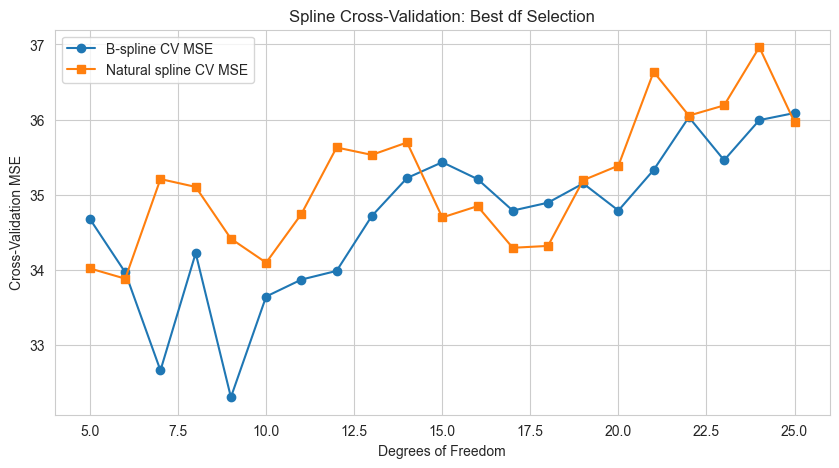

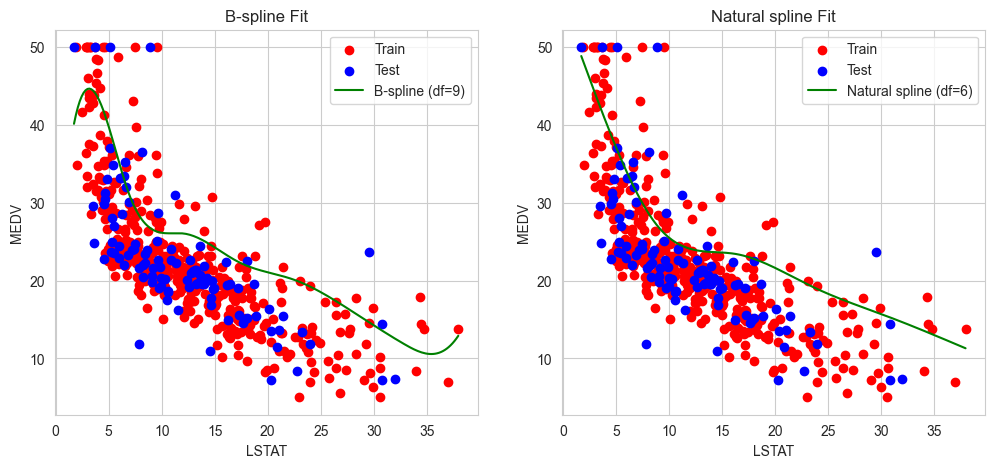

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from patsy import dmatrix
from sklearn.datasets import fetch_openml

# ---- Load dataset ----
boston = fetch_openml(name="boston", version=1, as_frame=True)
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data["medv"] = boston.target

# ---- Define variables ----
X = data["LSTAT"].values
y = data["medv"].values

# ---- Train-test split ----
np.random.seed(42)
train_index = np.random.choice(range(len(X)), size=400, replace=False)
test_index = np.setdiff1d(np.arange(len(X)), train_index)

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# ---- Helper: cross-validation to find best df ----
def cross_validate_spline(X, y, df_range, spline_type="bs", k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mean_mse = []

    for df in df_range:
        mse_fold = []

        for train_idx, val_idx in kf.split(X):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]

            # build spline basis
            if spline_type == "bs":
                X_train_spline = dmatrix(f"bs(x, df={df}, degree=3, include_intercept=False)",
                                         {"x": X_train_cv}, return_type='dataframe')
                X_val_spline = dmatrix(f"bs(x, df={df}, degree=3, include_intercept=False)",
                                       {"x": X_val_cv}, return_type='dataframe')
            else:  # natural spline
                X_train_spline = dmatrix(f"cr(x, df={df})",
                                         {"x": X_train_cv}, return_type='dataframe')
                X_val_spline = dmatrix(f"cr(x, df={df})",
                                       {"x": X_val_cv}, return_type='dataframe')

            # fit model
            model = LinearRegression().fit(X_train_spline, y_train_cv)
            pred = model.predict(X_val_spline)
            mse_fold.append(mean_squared_error(y_val_cv, pred))

        mean_mse.append(np.mean(mse_fold))

    return mean_mse

# ---- Run cross-validation ----
df_range = range(5, 26)
mse_bs = cross_validate_spline(X_train, y_train, df_range, spline_type="bs")
mse_ns = cross_validate_spline(X_train, y_train, df_range, spline_type="ns")

best_df_bs = df_range[np.argmin(mse_bs)]
best_df_ns = df_range[np.argmin(mse_ns)]

print(f"Best df (bs): {best_df_bs}, CV MSE: {min(mse_bs):.3f}")
print(f"Best df (ns): {best_df_ns}, CV MSE: {min(mse_ns):.3f}")

# ---- Evaluate test MSE using best df ----
X_train_bs = dmatrix(f"bs(x, df={best_df_bs}, degree=3, include_intercept=False)",
                     {"x": X_train}, return_type='dataframe')
X_test_bs = dmatrix(f"bs(x, df={best_df_bs}, degree=3, include_intercept=False)",
                    {"x": X_test}, return_type='dataframe')

X_train_ns = dmatrix(f"cr(x, df={best_df_ns})",
                     {"x": X_train}, return_type='dataframe')
X_test_ns = dmatrix(f"cr(x, df={best_df_ns})",
                    {"x": X_test}, return_type='dataframe')

model_bs = LinearRegression().fit(X_train_bs, y_train)
model_ns = LinearRegression().fit(X_train_ns, y_train)

pred_bs = model_bs.predict(X_test_bs)
pred_ns = model_ns.predict(X_test_ns)

test_mse_bs = mean_squared_error(y_test, pred_bs)
test_mse_ns = mean_squared_error(y_test, pred_ns)

print(f"Test MSE (bs, df={best_df_bs}): {test_mse_bs:.3f}")
print(f"Test MSE (ns, df={best_df_ns}): {test_mse_ns:.3f}")

# ---- Plot CV MSE vs df ----
plt.figure(figsize=(10,5))
plt.plot(df_range, mse_bs, 'o-', label="B-spline CV MSE")
plt.plot(df_range, mse_ns, 's-', label="Natural spline CV MSE")
plt.xlabel("Degrees of Freedom")
plt.ylabel("Cross-Validation MSE")
plt.title("Spline Cross-Validation: Best df Selection")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Fitted Curve for Best Models ----
x_grid = np.linspace(min(X), max(X), 200)

X_grid_bs = dmatrix(f"bs(x, df={best_df_bs}, degree=3, include_intercept=False)",
                    {"x": x_grid}, return_type='dataframe')
X_grid_ns = dmatrix(f"cr(x, df={best_df_ns})",
                    {"x": x_grid}, return_type='dataframe')

y_pred_bs = model_bs.predict(X_grid_bs)
y_pred_ns = model_ns.predict(X_grid_ns)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_train, y_train, color='red', label='Train')
plt.scatter(X_test, y_test, color='blue', label='Test')
plt.plot(x_grid, y_pred_bs, color='green', label=f'B-spline (df={best_df_bs})')
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.title('B-spline Fit')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_train, y_train, color='red', label='Train')
plt.scatter(X_test, y_test, color='blue', label='Test')
plt.plot(x_grid, y_pred_ns, color='green', label=f'Natural spline (df={best_df_ns})')
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.title('Natural spline Fit')
plt.legend()
plt.show()
